In [27]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [28]:
from datasets import *

# train_X, test_X, train_y, test_y = get_xor_data(200)
train_X, test_X, train_y, test_y = get_circular_boundary_dataset(200)
len(train_X)

90

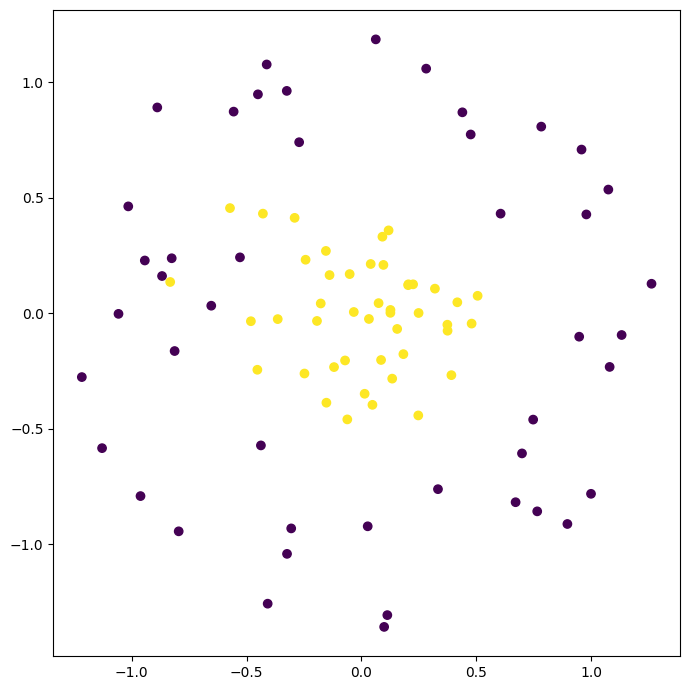

In [29]:
plot_2d_data(train_X,train_y)

In [30]:
s_params_size=1

In [31]:
dev = qml.device("default.qubit", wires=1)

def encode_and_rotate(x_i,s_params,w_params): 
    # input vector x   
    rx_angle = -2*s_params[0]*x_i[0]    
    ry_angle = -2*s_params[0]*x_i[1]
    qml.RY(ry_angle,0)
    qml.RX(rx_angle,0)
    qml.RX(-2*w_params[0],0)    
    qml.RY(-2*w_params[1],0)
    qml.RZ(-2*w_params[2],0)    

In [32]:
@qml.qnode(dev)
def vqc_model(x_i, params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev)
def get_state(x_i,params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    encode_and_rotate(x_i, s_params,w_params)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]


In [33]:
def loss(data, labels, model, params):    
    loss_sum = []
    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        if (model_output<0 and true_label>0) or (model_output>0 and true_label<0):
#             print(model_output, true_label)
            loss_sum.append((model_output - true_label) ** 2)

    return sum(loss_sum)/len(data)
#     return sum(loss_sum)/len(loss_sum)
#     return loss_sum / len(data)


def make_prediction(model, data_point, params):
    measurement_result = model(data_point, params)
    if measurement_result < 0:
        return -1
    return 1


def compute_accuracy(data, labels, model, params):
    n_samples = len(data)
#     for x in range(n_samples):
#         print(make_prediction(model, data[x], params),labels[x])
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

In [34]:
def get_initial_dataset(train_X,train_Y):
    size_to_return = int(0.04*len(train_X))
    curr_train_X, curr_train_y = [],[]
    idx = np.random.choice(len(train_X), size_to_return)
    for i in idx:
        curr_train_X.append(train_X[i])        
        curr_train_y.append(train_Y[i])
    curr_train_X = np.array(curr_train_X, requires_grad=False)
    curr_train_y = np.array(curr_train_y, requires_grad=False)
    return curr_train_X,curr_train_y

In [50]:
# start_point_itrs = 50

# for _ in range(start_point_itrs):
# print("__________________________________________________")
s_params_size, w_params_size = 1,3
# params = np.random.normal(size=(s_params_size+w_params_size))#*100
params = np.array([ 1.00302379, -0.03861783,  0.08039802,  1.81841197]) # these weights work very well with circular boundary
print(params)
# opt = qml.AdamOptimizer(stepsize=0.00087)
opt = qml.GradientDescentOptimizer(stepsize=0.009)
num_its = 220
loss_over_time = []
# curr_train_X, curr_train_y = get_initial_dataset(train_X,train_y)
for itr in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)
    print("Iteration:",itr, "Loss:",_loss)



[ 1.00302379 -0.03861783  0.08039802  1.81841197]
Iteration: 0 Loss: 0.2252766271250552
Iteration: 1 Loss: 0.22349638424430607
Iteration: 2 Loss: 0.22173496406042853
Iteration: 3 Loss: 0.21999250001863466
Iteration: 4 Loss: 0.21826910864791146
Iteration: 5 Loss: 0.2165648900121045
Iteration: 6 Loss: 0.21487992817291782
Iteration: 7 Loss: 0.21321429166299907
Iteration: 8 Loss: 0.21156803396734333
Iteration: 9 Loss: 0.2099411940113252
Iteration: 10 Loss: 0.20833379665374474
Iteration: 11 Loss: 0.20674585318335026
Iteration: 12 Loss: 0.21633604291008865
Iteration: 13 Loss: 0.21511354402324936
Iteration: 14 Loss: 0.21390830022240115
Iteration: 15 Loss: 0.2239358400157536
Iteration: 16 Loss: 0.2229965435584977
Iteration: 17 Loss: 0.22207225225079175
Iteration: 18 Loss: 0.22116279636061056
Iteration: 19 Loss: 0.22026800378990843
Iteration: 20 Loss: 0.208345989859106
Iteration: 21 Loss: 0.20770854638199768
Iteration: 22 Loss: 0.19600165709945053
Iteration: 23 Loss: 0.19555645165965427
Iterati

Iteration: 210 Loss: 0.19129405546742673
Iteration: 211 Loss: 0.18018278024282225
Iteration: 212 Loss: 0.20240433592723805
Iteration: 213 Loss: 0.19131168387241942
Iteration: 214 Loss: 0.19129629289323935
Iteration: 215 Loss: 0.18018248467664738
Iteration: 216 Loss: 0.19129301343067545
Iteration: 217 Loss: 0.1801832522140657
Iteration: 218 Loss: 0.19129263775190006
Iteration: 219 Loss: 0.18018233287584956


In [58]:
training_accuracy = compute_accuracy(train_X, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")

Training accuracy = 0.8444444444444444
Testing accuracy = 0.8


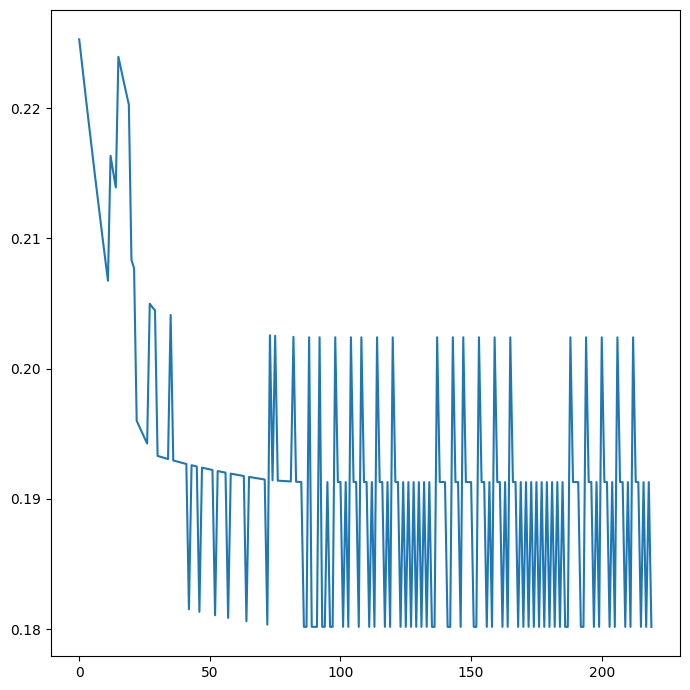

In [59]:
plt.plot(loss_over_time)
plt.show()

In [60]:
params

tensor([ 1.05098553, -0.02397638, -0.01621417,  1.81841197], requires_grad=True)

In [61]:

op_state = []
X,Y,Z=[],[],[]
markers=[]
colors=[]
for i in range(len(train_X)):
    x,y,z = (get_state(train_X[i],params))
    X.append(x)
    Y.append(y)
    Z.append(z)
    if train_y[i]==1:
        markers.append("o")
        colors.append('b')
    else:
        markers.append("^")
        colors.append('r')
    op_state.append([y,z])
op_state = np.array(op_state)
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)




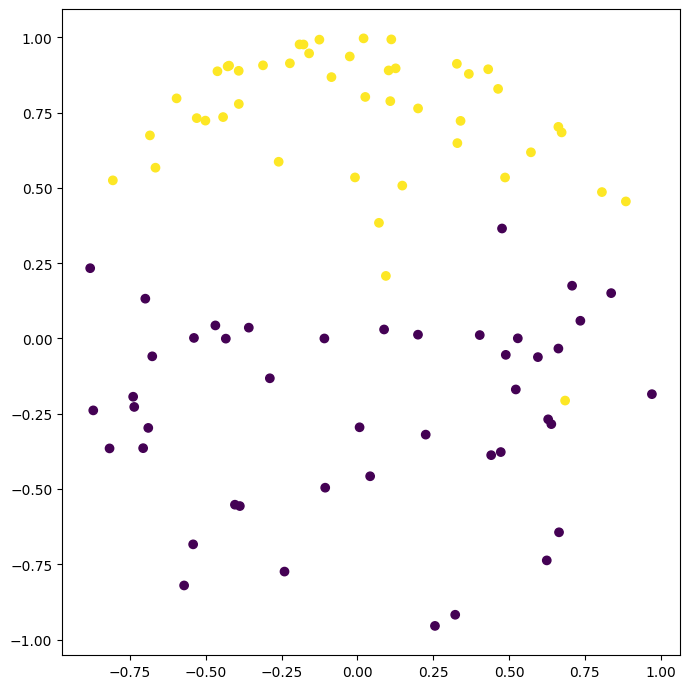

In [62]:
plot_2d_data(op_state,train_y)

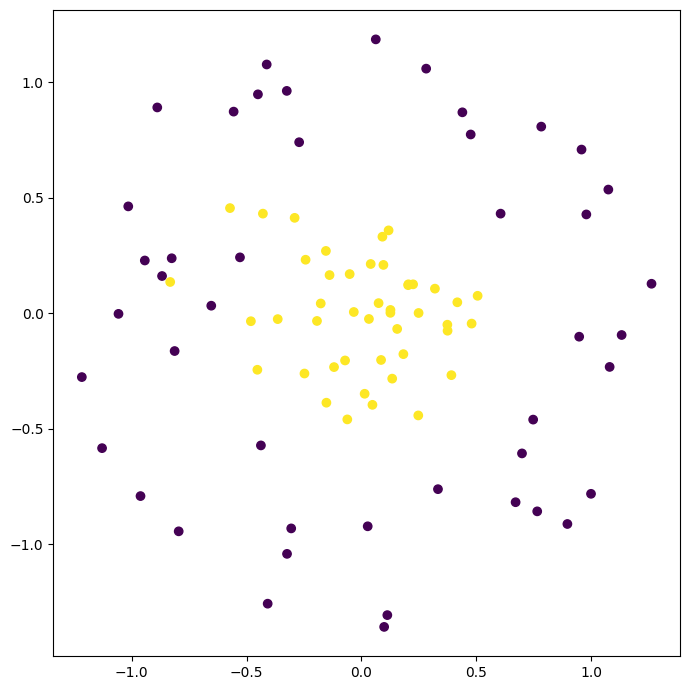

In [63]:
plot_2d_data(train_X,train_y)

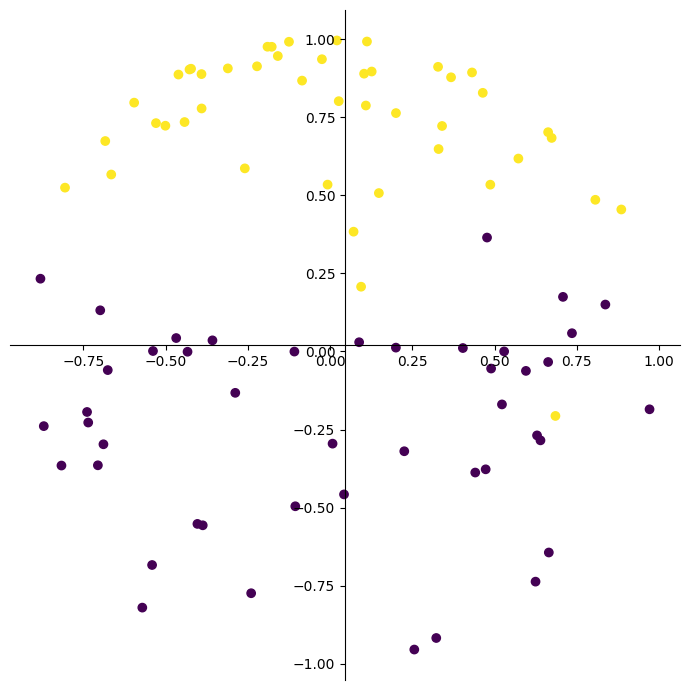

In [64]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.scatter(op_state[:, 0], op_state[:, 1], c=train_y)
# plt.legend(loc=1)
plt.show()

In [17]:
# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html
# when benchmarking the WINE and IRIS for ternary classification